In [ ]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



import pydot

In [ ]:
print(tf.__version__)
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

2.11.0


In [ ]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Please install GPU version of TF


Let us define methods to pre-process the tweets

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()



In [ ]:
pip show pandas

Name: pandas
Version: 1.3.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.9/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, cmdstanpy, cufflinks, datascience, db-dtypes, fastai, fix-yahoo-finance, google-colab, gspread-dataframe, holoviews, mizani, mlxtend, pandas-datareader, pandas-gbq, pandas-profiling, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray


In [ ]:
train_data= pd.read_csv("/content/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True) 
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("/content/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)


print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()


-------Train data--------
neutral     10704
positive     8375
negative     7673
Name: sentiment, dtype: int64
26752
-------------------------
-------Test data--------
neutral     1376
positive    1075
negative     983
Name: sentiment, dtype: int64
3434
-------------------------
Train Max Sentence Length :33
Test Max Sentence Length :32


In [ ]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

   


[[1, 58, 21, 4]]


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['text'].tolist()) )



x_train = pad_sequences(x_train, padding='post', maxlen=40)
x_valid = pad_sequences(x_valid, padding='post', maxlen=40)
x_test = pad_sequences(x_test, padding='post', maxlen=40)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))


Train data len:24076
Class distributionCounter({'neutral': 9633, 'positive': 7537, 'negative': 6906})
Valid data len:2676
Class distributionCounter({'neutral': 1071, 'positive': 838, 'negative': 767})


<ipython-input-18-1f651ba4dc1f>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
<ipython-input-18-1f651ba4dc1f>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
<ipython-input-18-1f651ba4dc1f>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

[  23    4    9   25    2    1   24  823  158    1  173    1 8795 6293
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'neutral', 'negative', 'neutral', 'negative', 'positive', 'positive', 'positive', 'neutral']
Text to number
[2 2 1 0 1 0 2 2 2 1]
Number to category
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break  

Streaming output truncated to the last 5000 lines.
[  11   66   73 1693    7    9   52  431    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  6 157  28 637   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0], shape=(40,), dtype=int32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  85    7   40    6  299  337 1127    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0], shape=(40,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[  56 1630    5 5337    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

In [ ]:
max_features =20000
embedding_dim =64
sequence_length = 40

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(3, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1280064   
                                                                 
 conv1d (Conv1D)             (None, 38, 128)           24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
______________________________________________

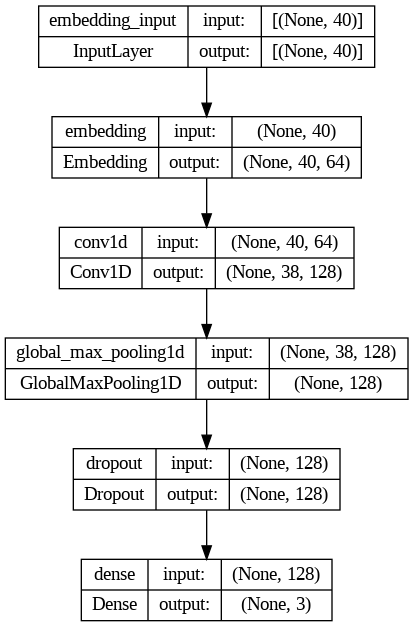

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

Let's train our model

In [ ]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100


/usr/local/lib/python3.9/dist-packages/keras/backend.py:5534: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


189/189 [==============================] - 8s 34ms/step - loss: 1.0609 - categorical_accuracy: 0.5466 - val_loss: 0.8166 - val_categorical_accuracy: 0.6913
Epoch 2/100
189/189 [==============================] - 6s 30ms/step - loss: 0.8022 - categorical_accuracy: 0.7026 - val_loss: 0.7826 - val_categorical_accuracy: 0.7111
Epoch 3/100
189/189 [==============================] - 6s 34ms/step - loss: 0.7644 - categorical_accuracy: 0.7291 - val_loss: 0.7879 - val_categorical_accuracy: 0.7216
Epoch 4/100
189/189 [==============================] - 6s 33ms/step - loss: 0.7392 - categorical_accuracy: 0.7454 - val_loss: 0.8011 - val_categorical_accuracy: 0.7205
Epoch 5/100
189/189 [==============================] - 7s 34ms/step - loss: 0.7206 - categorical_accuracy: 0.7616 - val_loss: 0.8179 - val_categorical_accuracy: 0.7250
Epoch 6/100
189/189 [==============================] - 6s 34ms/step - loss: 0.7059 - categorical_accuracy: 0.7808 - val_loss: 0.8327 - val_categorical_accuracy: 0.7280
Epoc

In [ ]:
history.history


{'loss': [1.1184933941157122,
  0.9531030511119315,
  0.937140321618676,
  0.9321290777557057,
  0.9306929732284033,
  0.9297630696384628,
  0.9284770882472304,
  0.9288732166661834,
  0.9282104888812394,
  0.927759382490661,
  0.927945953267895,
  0.9277907699460424,
  0.9255959105998659,
  0.926649411456651,
  0.9256454872756251,
  0.9257315206139523,
  0.9261224003780084,
  0.9238718759084702,
  0.9255811971848857,
  0.9242749989161481,
  0.9244924683589875,
  0.9244851126665292,
  0.9240543796267892,
  0.9244238607391089,
  0.9239372514890147,
  0.9228773908097001,
  0.9235429429477148,
  0.9235735056328603,
  0.9227947121760559,
  0.9232392680765803,
  0.9219240495722483,
  0.9217022830296403,
  0.9212131716916283,
  0.9213633643648003,
  0.9204544241314692,
  0.9216223735115342,
  0.9210897221440868,
  0.9203247021729615,
  0.9202566430663366,
  0.9196080654478287,
  0.9204519045850054,
  0.9196680740851424,
  0.9202468657655997,
  0.9200666908668034,
  0.9193181528128507,
  0.91

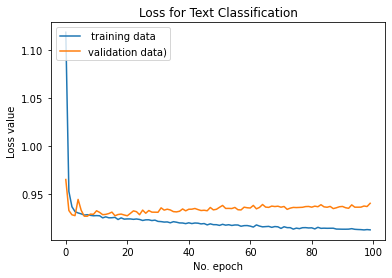

In [ ]:

plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

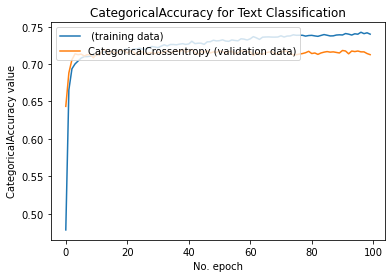

In [ ]:


plt.plot(history.history['CategoricalAccuracy'], label=' (training data)')
plt.plot(history.history['val_CategoricalAccuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()


Lets save our model and tokenizer

In [ ]:
model.save('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel') 
json_string = tokenizer.to_json()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\TweetSenitment\savedTFCNNModel\tf_cnnmodel\assets


In [ ]:
import json
with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

Lets load our model and test on test data

In [ ]:
new_model = tf.keras.models.load_model('C:\\TweetSenitment\\savedTFCNNModel\\tf_cnnmodel')
new_model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 40, 64)            1280064   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 38, 128)           24704     
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,305,155
Trainable params: 1,305,155
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with open('C:\\TweetSenitment\\savedTFCNNModel\\tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [ ]:
x_test  = np.array( tokenizer1.texts_to_sequences(test_data['text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=40)

d:\tensorflow\tf\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:

# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)


Generate predictions for all samples
[[1.4229332e-01 8.9901769e-01 1.8149537e-01]
 [2.7187658e-03 3.2710705e-02 9.8550016e-01]
 [9.5976716e-01 7.5771965e-02 1.0393349e-02]
 ...
 [7.8557450e-01 3.6724645e-01 2.9643273e-02]
 [8.9249731e-04 1.3467870e-02 9.9620050e-01]
 [2.2294002e-03 2.6725024e-02 9.8878294e-01]]


In [ ]:
test_data['pred_sentiment']= predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'neutral',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '2'),'positive',test_data.pred_sentiment)

In [ ]:
labels = ['positive', 'negative','neutral']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    positive       0.74      0.78      0.76      1075
    negative       0.70      0.68      0.69       983
     neutral       0.68      0.67      0.67      1376

    accuracy                           0.71      3434
   macro avg       0.71      0.71      0.71      3434
weighted avg       0.70      0.71      0.70      3434

